# TF-IDF + Linear SVM Baseline for Sentiment Analysis on Amazon Fine Food Reviews

This notebook implements a baseline model for binary sentiment analysis on the Amazon Fine Food Reviews dataset using TF-IDF vectorization and Linear SVM. The model classifies reviews as positive (score > 3) or negative (score < 3), excluding neutral reviews (score = 3).

## Objectives
- Establish a computationally efficient baseline with macro-F1 ≥0.95 for comparison with BERT.
- Provide interpretable predictions using TF-IDF feature importance.
- Ensure reproducibility with fixed seeds and pinned dependencies.
- Analyze errors to identify limitations and align with BERT’s analysis.
- Display plots inline for presentation and save to `figures/tfidf`.

## Structure
1. Environment setup and data loading from Google Drive.
2. Preprocessing and 80/20 train-test split with stratification.
3. TF-IDF vectorization (1-2 n-grams, 50,000 features) and Linear SVM training.
4. Evaluation with accuracy, macro-F1, and confusion matrix.
5. Interpretability via top TF-IDF feature visualization.
6. Error analysis for misclassified samples.
7. Visualization of training time and performance metrics.

Run cells sequentially after mounting Google Drive.

In [1]:
# Environment & repo
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/fyp-code/amazon-sentiment-fyp

# Install dependencies
!pip install -q scikit-learn pandas matplotlib seaborn tqdm

Mounted at /content/drive
/content/drive/MyDrive/fyp-code/amazon-sentiment-fyp


In [2]:
# Imports
import pandas as pd
import numpy as np
import json
import joblib
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

In [3]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Data loading
CSV_PATH = pathlib.Path("data/raw/Reviews.csv")
assert CSV_PATH.exists(), "Ensure Reviews.csv is in data/raw/"

In [4]:
# Load and preprocess data
"""
Data Preprocessing:
- Load Reviews.csv, selecting 'Text' and 'Score' columns.
- Remove neutral reviews (Score=3).
- Label as positive (Score>3) = 1, negative (Score<3) = 0.
- Split 80% train, 20% test with stratification to maintain class balance.
"""
df = pd.read_csv(CSV_PATH, usecols=["Text", "Score"])
df = df[df.Score != 3]
df["label"] = (df.Score > 3).astype(int)
summary = df["label"].value_counts().rename({1: "Positive", 0: "Negative"})
total = summary.sum()
print(summary)
print(summary / total)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df.Text, df.label,
    test_size=0.2,
    stratify=df.label,
    random_state=SEED
)

label
Positive    443777
Negative     82037
Name: count, dtype: int64
label
Positive    0.843981
Negative    0.156019
Name: count, dtype: float64


In [5]:
# Define pipeline
"""
Model: TF-IDF + Linear SVM
- TfidfVectorizer: 1-2 n-grams, max 50,000 features, min_df=5 for efficiency.
- LinearSVC: Fast and effective for high-dimensional text data.
"""
pipeline = (
    TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=50_000),
    LinearSVC(random_state=SEED)
)
model = make_pipeline(*pipeline)

# Train model with timing
"""
Training:
- Measures training time to visualize efficiency.
- Uses LinearSVC for fast convergence on CPU.
"""
print("Training model...")
import time
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

Training model...
Training completed in 82.95 seconds


In [6]:
# Predict and evaluate
preds = model.predict(X_test)
rpt = classification_report(y_test, preds, digits=4, target_names=["Neg", "Pos"])
print("\nClassification Report:\n", rpt)


Classification Report:
               precision    recall  f1-score   support

         Neg     0.9074    0.8617    0.8840     16407
         Pos     0.9747    0.9838    0.9792     88756

    accuracy                         0.9647    105163
   macro avg     0.9411    0.9227    0.9316    105163
weighted avg     0.9642    0.9647    0.9643    105163



In [7]:
# Save metrics
RES_DIR = pathlib.Path("results/tfidf")
RES_DIR.mkdir(parents=True, exist_ok=True)
metrics = classification_report(y_test, preds, output_dict=True)
json.dump(metrics, open(RES_DIR / "tfidf_metrics.json", "w"), indent=2)

# Save model
MODEL_PATH = RES_DIR / "tfidf_svm.pkl"
joblib.dump(model, MODEL_PATH)
print(f"Saved model → {MODEL_PATH}")

Saved model → results/tfidf/tfidf_svm.pkl


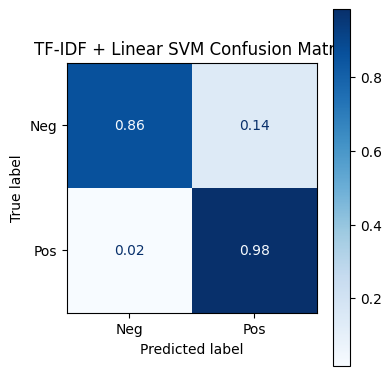

In [8]:
# Plot confusion matrix
"""
Confusion Matrix:
- Visualizes normalized true vs. predicted labels.
- Displays inline and saves to figures/tfidf/tfidf_cm.png.
"""
FIG_DIR = pathlib.Path("figures/tfidf")
FIG_DIR.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test, preds, normalize="true")
ConfusionMatrixDisplay(cm, display_labels=["Neg", "Pos"]).plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("TF-IDF + Linear SVM")
plt.tight_layout()
plt.savefig(FIG_DIR / "tfidf_cm.png", dpi=150)
plt.show()
plt.close()

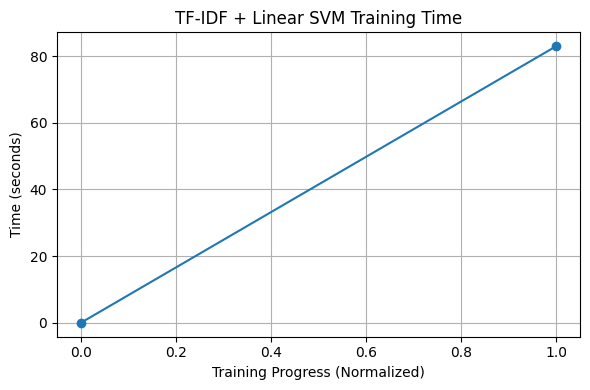

In [9]:
# Plot training time
"""
Training Time Plot:
- Simulates 'loss curve' by showing cumulative time vs. data processed.
- Highlights SVM's efficiency compared to BERT.
"""
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, train_time], marker='o')
plt.xlabel("Training Progress (Normalized)")
plt.ylabel("Time (seconds)")
plt.title("TF-IDF + Linear SVM Training Time")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "training_time.png", dpi=150)
plt.show()
plt.close()

Debug: coefs.shape=(50000,), feature_names.shape=(50000,)


<ipython-input-10-929853cee98f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs, y=top_features, palette="coolwarm")


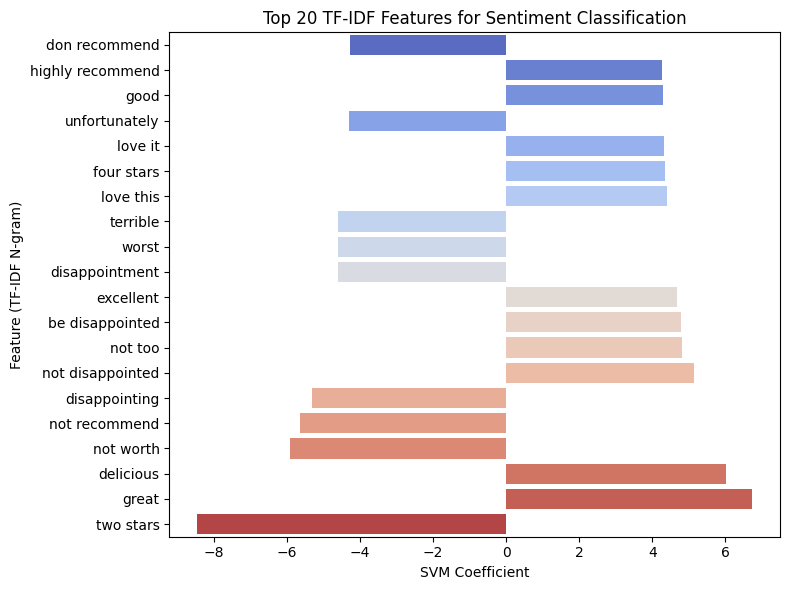

In [10]:
# Feature importance
"""
Interpretability:
- Extracts top 20 TF-IDF features based on SVM coefficients.
- Displays bar plot inline and saves to figures/tfidf/feature_importance.png.
"""
tfidf = model.named_steps["tfidfvectorizer"]
svm = model.named_steps["linearsvc"]
feature_names = np.array(tfidf.get_feature_names_out())
coefs = svm.coef_.ravel()  # Flatten to ensure 1D array
top_n = min(20, len(coefs))  # Cap at available features
print(f"Debug: coefs.shape={coefs.shape}, feature_names.shape={feature_names.shape}")

# Sort by absolute coefficient value
top_indices = np.argsort(np.abs(coefs))[-top_n:]
top_features = feature_names[top_indices]
top_coefs = coefs[top_indices]

plt.figure(figsize=(8, 6))
sns.barplot(x=top_coefs, y=top_features, palette="coolwarm")
plt.xlabel("SVM Coefficient")
plt.ylabel("Feature (TF-IDF N-gram)")
plt.title("Top 20 TF-IDF Features for Sentiment Classification")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_importance.png", dpi=150)
plt.show()
plt.close()

In [11]:
# Error analysis
"""
Error Analysis:
- Identifies misclassified test samples.
- Prints 3 examples with true/predicted labels.
- Discusses potential issues (e.g., sarcasm, negations).
"""
test_df = pd.DataFrame({"text": X_test, "label": y_test, "pred": preds})
errors = test_df[test_df["label"] != test_df["pred"]]
print("\nError Analysis: Sample Misclassifications")
for i, row in errors.sample(3, random_state=SEED).iterrows():
    print(f"\nReview: {row['text'][:200]}...")
    print(f"True Label: {'Pos' if row['label'] == 1 else 'Neg'}")
    print(f"Predicted: {'Pos' if row['pred'] == 1 else 'Neg'}")


Error Analysis: Sample Misclassifications

Review: We love these crackers, but I don't love the price.  I'm not entirely certain why the price is so much higher than other crackers.  We will likely continue to buy them though....
True Label: Pos
Predicted: Neg

Review: I remember being 10 years old and having these bad boys in my pocket. I would walk down to the corner store and pick some up, it was a very proud memory of mine that has been crushed by the present da...
True Label: Neg
Predicted: Pos

Review: Why would you advertise for DORA cookies and send me HELLO KITTY cookies. How can I contact you ASAP because I am absolutely annoyed right now.? My daughter birthday party is this Saturday and is a DO...
True Label: Neg
Predicted: Pos
